In [1]:
%load_ext autoreload
%autoreload 2

from evaluation_scripts.base import load_json, get_base_pathes
import pandas as pd
import os
from evaluation_scripts.base import load_pickle_obj
from model_scripts.sensitivity_evaluation import ParameterSetEvaluation, SensitivityAnalysis
from model_scripts.kernel_collector import KernelCollector
import matplotlib.pyplot as plt
from model_scripts.lda_kernel_plotter import KernelPlot
from model_scripts.grid import GridPoint, MakeGrid

date = "16052023"
name_add = "_preexisting"
_, base = get_base_pathes()
path = os.path.join(base, "sensitivity_sim")

In [2]:
sensitivity = SensitivityAnalysis(path, parameter_names = ["turnover",
                                "infection", "cA", "cB", "cS", "cU", "cAB"], name_add = name_add)
reload = False
if reload:
    sensitivity.load()
else:
    sims = pd.read_pickle(os.path.join(path, "sensitivity_sim"+name_add+".pkl"))
    pars = pd.read_pickle(os.path.join(path, "sensitivity_par"+name_add+".pkl"))
    sensitivity.evaluate_parameter_sets(sims, pars)
sensitivity.lda()
sensitivity.join_eval_data()

In [3]:
import seaborn as sns
colors = dict(zip(sensitivity.strategies, sns.color_palette("pastel")))
text_placement_y = {"turnover":.02, "infection":-.04, "cA":-.02, "cB":.02, "cS":.04, "cU":-.04, "cAB":.03}


In [4]:
def plot_original_axes(ax, lda_directions, parameter_names, text_placement_y, arrow_length=0.75, adjust = 1, head_adjust = 0.01):
        for param in parameter_names:
            color = 'black'  # Set the color to black
            direction = lda_directions[param].values
            ax.arrow(0, 0, direction[0] * arrow_length, direction[1] * arrow_length,
                          head_width=head_adjust, head_length=head_adjust, fc=color, ec=color)
            
            ax.text(direction[0] * arrow_length * adjust, direction[1]
                         * arrow_length *adjust + text_placement_y[param], param, color=color, fontsize=15)

In [104]:
df = sensitivity.evaluations_df.sample(100)
df = sensitivity.evaluations_df

In [6]:
scenario1 = {
       "UI_mean":"Combo",
       "infection":0.3, 
       "turnover":.2,
       "cA":0.053,
       "cB":0.053,
       "cS":0.745,
       "cU":0.149,
       "cAB":0,
       "name":"Scenario1"}
scenario2 = {
       "UI_mean":"Combo",
       "infection":0.35,
       "turnover":0.2,
       "cA":0.106,
       "cB":0.106,
       "cS":0.586,
       "cU":0.149,
       "cAB":0.053,
       "name":"Scenario2"}
scenario3 = {
       "UI_mean":"Combo",
       "infection":0.25,
       "turnover":.5,
       "cA":0.5,
       "cB":0.5,
       "cS":0,
       "cU":0,
       "cAB":0,
       "name":"Scenario3"}
experiments = pd.DataFrame().from_dict([scenario1, scenario2, scenario3])
experiments


,UI_mean,infection,turnover,cA,cB,cS,cU,cAB,name
0,Combo,0.30,0.2,0.053,0.053,0.745,0.149,0.000,Scenario1
1,Combo,0.35,0.2,0.106,0.106,0.586,0.149,0.053,Scenario2
2,Combo,0.25,0.5,0.500,0.500,0.000,0.000,0.000,Scenario3


In [7]:
def get_lda_XY(lda_directions, df):
        cols = lda_directions.columns
        data = df[cols]
        pX = lda_directions.loc[0, ]
        pY = lda_directions.loc[1, ]
        df["ldaX"] = data.apply(lambda x: (x*pX).sum(), axis = 1)
        df["ldaY"] = data.apply(lambda x: (x*pY).sum(), axis = 1)
        return df
    
experiments = get_lda_XY(sensitivity.parameter_directions, experiments)
experiments

,UI_mean,infection,turnover,cA,cB,cS,cU,cAB,name,ldaX,ldaY
0,Combo,0.30,0.2,0.053,0.053,0.745,0.149,0.000,Scenario1,-0.000281,0.079853
1,Combo,0.35,0.2,0.106,0.106,0.586,0.149,0.053,Scenario2,0.030436,0.069576
2,Combo,0.25,0.5,0.500,0.500,0.000,0.000,0.000,Scenario3,0.664193,-0.063070


In [16]:
def plot_experiments(ax, experiments, markersize = 500, edgecolors = "black", yspace = [0.03, 0.03, 0.03], xspace = [0, 0, 0]):
    sns.scatterplot(data=experiments, x="ldaX", y="ldaY", s = markersize, marker = "*",
            hue="UI_mean", alpha=1,  legend=False)
    for i, exp in experiments.iterrows():
        ldaX = exp["ldaX"]
        ldaY = exp["ldaY"]
        ax.text(ldaX + xspace[i], ldaY + yspace[i], exp["name"], color="black", fontsize=15)


In [14]:
df.winning_strategy.replace({"None":"No Winner"}, inplace = True)
colors.update({"No Winner":(0.2,0.2,0.2)})
colors

{'Combination': (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 'Cycling': (1.0, 0.7058823529411765, 0.5098039215686274),
 'Mixing': (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 'Mono A': (1.0, 0.6235294117647059, 0.6078431372549019),
 'Mono B': (0.8156862745098039, 0.7333333333333333, 1.0),
 'No treatment': (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 'No Winner': (0.2, 0.2, 0.2)}

In [10]:
df

strategy,rep,Combination,Cycling,Mixing,Mono A,Mono B,cU,cS,cA,cB,A&B,cAB,turnover,infection,winning_group,winning_strategy,LDA_axis_1,LDA_axis_2
0,0,0.619681,0.454787,0.406915,0.460106,0.409574,0.24,0.05,0.24,0.23,0.0,0.24,0.86,0.20,Combination,Combination,0.697303,0.003358
1,1,0.632979,0.401596,0.438830,0.457447,0.372340,0.24,0.05,0.24,0.23,0.0,0.24,0.86,0.20,Combination,Combination,0.697303,0.003358
2,2,0.611702,0.473404,0.446809,0.462766,0.406915,0.24,0.05,0.24,0.23,0.0,0.24,0.86,0.20,Combination,Combination,0.697303,0.003358
3,3,0.638298,0.481383,0.438830,0.484043,0.385638,0.24,0.05,0.24,0.23,0.0,0.24,0.86,0.20,Combination,Combination,0.697303,0.003358
4,4,0.640957,0.486702,0.444149,0.436170,0.420213,0.24,0.05,0.24,0.23,0.0,0.24,0.86,0.20,Combination,Combination,0.697303,0.003358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,0.265957,0.273936,0.276596,0.231383,0.273936,0.18,0.15,0.21,0.11,0.0,0.35,0.26,0.39,Combination-Cycling,Combination,0.073438,-0.014279
99996,6,0.361702,0.295213,0.276596,0.234043,0.247340,0.18,0.15,0.21,0.11,0.0,0.35,0.26,0.39,Combination-Cycling,Combination,0.073438,-0.014279
99997,7,0.321809,0.250000,0.234043,0.234043,0.234043,0.18,0.15,0.21,0.11,0.0,0.35,0.26,0.39,Combination-Cycling,Combination,0.073438,-0.014279
99998,8,0.369681,0.316489,0.287234,0.204787,0.231383,0.18,0.15,0.21,0.11,0.0,0.35,0.26,0.39,Combination-Cycling,Combination,0.073438,-0.014279


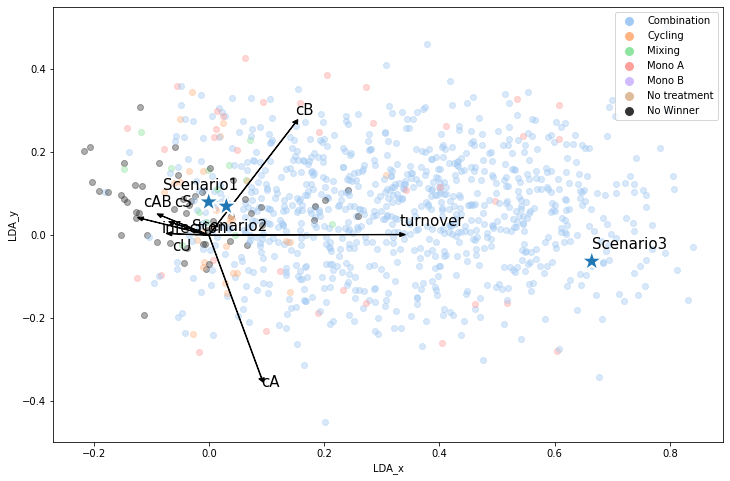

In [18]:
from random import random
fig, ax = plt.subplots(figsize = (12,8))

ldax, lday = df.LDA_axis_1[0::100], df.LDA_axis_2[0::100]
p = 1
counter = 0
for x, y in zip(ldax, lday):
    if p > random():
        counter += 1
        data = df[(df.LDA_axis_1 == x) & (df.LDA_axis_2 == y)]
        av_winner = data.winning_strategy.value_counts().idxmax()
        ax.scatter(x = x, y = y, color = colors[av_winner], marker = "o", alpha = 0.4)

plot_original_axes(ax, sensitivity.parameter_directions, sensitivity.parameter_names, text_placement_y, arrow_length=0.4)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in colors.items()]

plot_experiments(ax, experiments, yspace = [0.03, -0.06, 0.03], xspace = [-0.08, -.06, 0])
# Add the custom legend to the plot
plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel("LDA_x")
plt.ylabel("LDA_y")
plt.savefig(os.path.join(path, "lda_raw.png"), dpi = 300)



In [27]:
winning_A = df[df.winning_strategy == "Mono A"]
winning_A[["cU", "cS", "cA", "cB", "cAB"]].mean()

strategy
cU     0.232082
cS     0.199123
cA     0.157918
cB     0.146137
cAB    0.264740
dtype: float64

In [29]:
winning_B = df[df.winning_strategy == "Mono B"]
winning_B

strategy,rep,Combination,Cycling,Mixing,Mono A,Mono B,cU,cS,cA,cB,A&B,cAB,turnover,infection,winning_group,winning_strategy,LDA_axis_1,LDA_axis_2


In [54]:
def loser(x):
    strategies = ["Combination", "Cycling", "Mixing", "Mono A", "Mono B"]    
    y =  x[strategies]
    return y[y == y.min()].index[0]

In [56]:
df["loser"] = df.apply(lambda x: loser(x), axis = 1)

In [124]:
def make_mean(sub_df):
    mean_df = sub_df.mean()
    mean_df["n"] = len(sub_df)
    mean_df.name = strategy
    return mean_df.to_frame().T

In [128]:
losers = []
winners = []
params = ["cU", "cS", "cA", "cB", "cAB", "turnover", "infection"]
winners = []
for strategy in  ["Combination", "Cycling", "Mixing", "Mono A", "Mono B"]:
    sub_df = df[df["loser"] == strategy][params]
    losers.append(make_mean(sub_df))
    sub_df_win = df[df["winning_strategy"] == strategy][params]
    winners.append(make_mean(sub_df_win))
losers = pd.concat(losers)
winners = pd.concat(winners)

In [129]:
losers

strategy,cU,cS,cA,cB,cAB,turnover,infection,n
Combination,0.253295,0.219285,0.154299,0.130311,0.242811,0.209126,0.661864,1384.0
Cycling,0.234150,0.201040,0.179306,0.146013,0.239491,0.407243,0.613143,4537.0
Mixing,0.231406,0.204636,0.185225,0.145193,0.233539,0.424655,0.605285,5326.0
Mono A,0.226710,0.192883,0.274208,0.113795,0.192404,0.477703,0.478949,31167.0
Mono B,0.216538,0.193957,0.151842,0.250763,0.186899,0.520302,0.483927,57586.0


In [130]:
winners

strategy,cU,cS,cA,cB,cAB,turnover,infection,n
Combination,0.218362,0.192123,0.197943,0.204706,0.186866,0.526506,0.484138,86760.0
Cycling,0.225108,0.207965,0.173203,0.176407,0.217316,0.141645,0.390823,2310.0
Mixing,0.225820,0.229098,0.158115,0.158770,0.228197,0.151475,0.440902,1220.0
Mono A,0.232082,0.199123,0.157918,0.146137,0.264740,0.523836,0.557233,3650.0
Mono B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
